In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import dill

from constants import *
from EKF_funcs import EKF, Q
from force_models import twoBody
from record_data import data, write_data, read_data
from orb_elem_conversion import walker_delta, kep2car
from plotting import *

/home/koe/anaconda3/lib/python3.9/site-packages/dill/_dill.py:970: UnpicklingWarning: Creating a new PyCapsule None for a C data structure that may not be present in memory. Segmentation faults or other memory errors are possible.
  warnings.warn('Creating a new PyCapsule %s for a C data structure that may not be present in memory. Segmentation faults or other memory errors are possible.' % (name,), UnpicklingWarning)


In [2]:
lat,lon = 30*np.pi/180,120*np.pi/180
s_4 = Rearth * np.array([np.cos(lon)*np.cos(lat), np.sin(lon)*np.cos(lat), np.sin(lat)])

lat,lon = 10*np.pi/180,20*np.pi/180
s_5 = Rearth * np.array([np.cos(lon)*np.cos(lat), np.sin(lon)*np.cos(lat), np.sin(lat)])

lat,lon = -25*np.pi/180,80*np.pi/180
s_6 = Rearth * np.array([np.cos(lon)*np.cos(lat), np.sin(lon)*np.cos(lat), np.sin(lat)])

lat,lon = 0*np.pi/180,280*np.pi/180
s_7 = Rearth * np.array([np.cos(lon)*np.cos(lat), np.sin(lon)*np.cos(lat), np.sin(lat)])

lat,lon = 20*np.pi/180,340*np.pi/180
s_8 = Rearth * np.array([np.cos(lon)*np.cos(lat), np.sin(lon)*np.cos(lat), np.sin(lat)])

lat,lon = -30*np.pi/180,180*np.pi/180
s_9 = Rearth * np.array([np.cos(lon)*np.cos(lat), np.sin(lon)*np.cos(lat), np.sin(lat)])

lat,lon = -10*np.pi/180,0*np.pi/180
s_10 = Rearth * np.array([np.cos(lon)*np.cos(lat), np.sin(lon)*np.cos(lat), np.sin(lat)])

In [3]:
import scipy.spatial.transform

def rotate(vector,axis,angle):
    """Rotate a vector about an axis by an angle (in radians). Works also for 6D state vectors."""
    axis = axis / np.linalg.norm(axis)
    if vector.shape[0] == 6:
        return scipy.spatial.transform.Rotation.from_rotvec(angle * axis).apply(vector.reshape(2,3)).reshape(6)
    else:
        return scipy.spatial.transform.Rotation.from_rotvec(angle * axis).apply(vector)

In [173]:
t_init = init_epoch_s
t_fin = init_epoch_s + DAY_s
t_eval = np.arange(t_init, t_fin + 5*MINUTE_s, 5*MINUTE_s)

# constellation = walker_delta(100, 10, 45*np.pi/180)
# satellite_init_states = [kep2car(sat) for sat in constellation]
# satellite_orbs = [
#     scipy.integrate.solve_ivp(
#         lambda t, s: np.concatenate([s[3:], twoBody(s)]),
#         t_span = [t_eval[0], t_eval[-1]],
#         t_eval = t_eval,
#         rtol = 1e-8,
#         atol = 1e-10,
#         y0 = sat_init_state
#     ) for sat_init_state in satellite_init_states
# ]

# with open("./code_data_files/orbits100.pkl", "wb") as f:
#     dill.dump(satellite_orbs, f)
    
with open("./code_data_files/orbits100.pkl", "rb") as f:
    satellite_orbs = dill.load(f)


# station_ecefs = [s_1, s_2, s_3]
station_ecefs = [s_1, s_2, s_3, s_4, s_5, s_6, s_7, s_8, s_9, s_10]


# alt = Rearth + 800e3
# vel = np.sqrt(muE/alt)
# object_init_states = [
#     rotate(np.array([alt, 0, 0, 0, -vel*np.cos(98.7*DEG2RAD), vel*np.sin(98.7*DEG2RAD)]),np.array([0,0,1]),np.pi/2)
# ]

alt = Rearth + 1200e3
vel = np.sqrt(muE/alt)
object_init_states = [
    np.array([alt, 0, 0, 0, vel*np.cos(70*DEG2RAD), vel*np.cos(20*DEG2RAD)]) 
]

obj_orbs = [
    scipy.integrate.solve_ivp(
        lambda t, s: np.concatenate([s[3:], twoBody(s)]),
        t_span = [t_eval[0], t_eval[-1]],
        t_eval = t_eval,
        rtol = 1e-8,
        atol = 1e-10,
        y0 = obj_init_state
    ) for obj_init_state in object_init_states
]
# with open("./code_data_files/orbitsobjects.pkl", "rb") as f:
#     obj_orbs = dill.load(f)

In [174]:
import dill

# Save the lambdified expressions to disk
# with open("./code_data_files/orbits1000.pkl", "wb") as f:
#     dill.dump(satellite_orbs, f)
    

# Save the lambdified expressions to disk
with open("./code_data_files/orbitsobjects3.pkl", "wb") as f:
    dill.dump(obj_orbs, f)

In [175]:
# with open("./code_data_files/obs.pkl", "rb") as f:
#     obs = dill.load(f)
obs = data(obj_orbs[0], satellite_orbs, station_ecefs, init_epoch_s)

In [176]:
obsn = obs[np.where(obs[:,0]==0)]
obsr = obs[np.where(obs[:,0]==1)]

In [177]:
with open("./code_data_files/obs2_100_0.pkl", "wb") as f:
    dill.dump(obsn, f)

with open("./code_data_files/obs2_0_10.pkl", "wb") as f:
    dill.dump(obsr, f)
    
with open("./code_data_files/obs2_100_10.pkl", "wb") as f:
    dill.dump(obs, f)

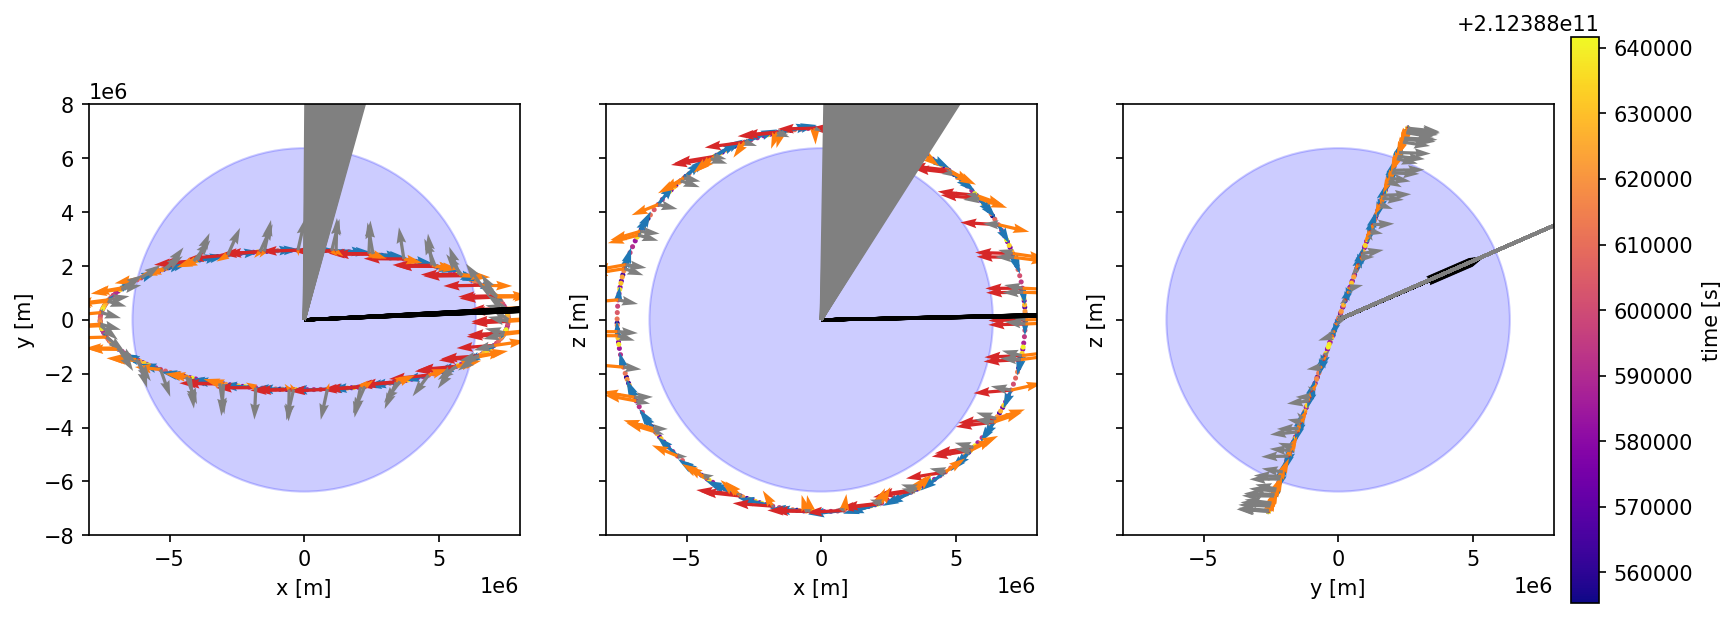

In [178]:
plot_eci(obj_orbs[0])

In [46]:
obs_diff = obs[np.where(np.diff(obs[:,2]) != 0)]

In [47]:
Xhats, Phats, Phis, Ss = EKF(object_init_states[0], init_epoch, obs)#obs_new)

100%|█████████████████████████████████████████| 203/203 [00:34<00:00,  5.84it/s]


In [48]:
XhatsR, PhatsR, PhisR, SsR = EKF(object_init_states[0], init_epoch, obs[np.where(obs[:,0]==1)])#obs_new)

100%|█████████████████████████████████████████| 164/164 [00:34<00:00,  4.74it/s]


In [49]:
XhatsO, PhatsO, PhisO, SsO = EKF(object_init_states[0], init_epoch, obs[np.where(obs[:,0]==0)])#obs_new)

100%|███████████████████████████████████████████| 39/39 [00:19<00:00,  2.00it/s]


In [50]:
obs[:,2]

array([    0.,   300.,   600.,   900.,  1200.,  2100.,  2400.,  2700.,
        3000.,  4800.,  5100.,  5400.,  5400.,  5700.,  5700.,  7500.,
        7500.,  7800.,  8100.,  8400.,  8700.,  9600.,  9900., 10200.,
       10500., 10800., 11700., 12000., 12000., 12300., 12600., 12900.,
       13200., 13800., 14100., 14100., 15000., 15300., 15600., 15900.,
       15900., 16200., 16200., 17100., 17400., 17700., 18000., 18300.,
       19800., 20100., 20100., 20400., 20400., 20700., 21000., 22800.,
       23100., 23400., 23700., 24000., 24600., 24900., 25200., 25500.,
       25500., 25800., 27300., 27300., 27600., 27600., 27900., 27900.,
       28200., 28500., 30000., 30300., 30600., 30900., 31200., 31500.,
       32400., 32700., 33000., 33300., 33600., 33900., 34200., 35100.,
       35400., 35700., 36000., 36000., 36000., 37800., 38100., 38400.,
       38700., 39000., 39900., 39900., 40200., 40500., 40800., 41100.,
       42000., 42600., 42900., 43200., 43500., 45300., 45600., 45900.,
      

In [51]:
X = np.array(Xhats)

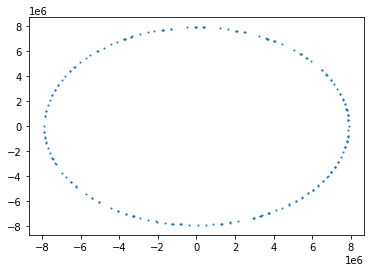

In [52]:
plt.scatter(X[:,0], X[:,1],s=1)

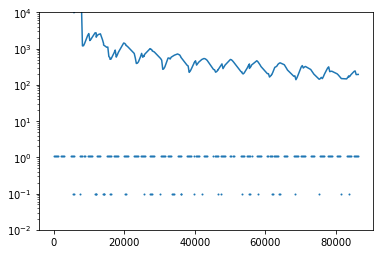

In [53]:
# P = np.array(Phis)
P_size = [np.sqrt(np.sum(np.square(np.trace(P_hat)))) for P_hat in Phats]

plt.plot(obs[:,2],P_size)
plt.ylim([0.01,10000])
plt.yscale('log')
plt.scatter(obs[:,2],obs[:,0]+0.1,s=1)

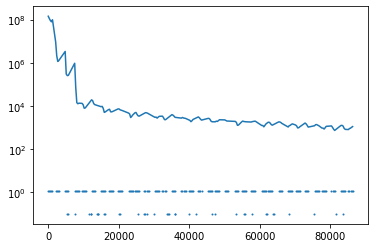

In [54]:
P_size = [np.sqrt(np.sum(np.square(np.trace(P_hat)))) for P_hat in PhatsR]
plt.plot(obs[np.where(obs[:,0]==1)][:,2],P_size)
# plt.ylim([0.01,10000])
plt.yscale('log')
plt.scatter(obs[:,2],obs[:,0]+0.1,s=1)

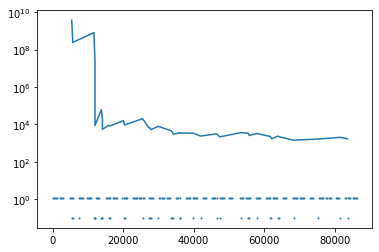

In [55]:
P_size = [np.sqrt(np.sum(np.square(np.trace(P_hat)))) for P_hat in PhatsO]
plt.plot(obs[np.where(obs[:,0]==0)][:,2],P_size)
# plt.ylim([0.01,10000])
plt.yscale('log')
plt.scatter(obs[:,2],obs[:,0]+0.1,s=1)

In [18]:
len(obs[np.where(obs[:,0]==0)][:,2])

386

In [19]:
obs[np.where(obs_diff[:,0]==0)][:,2]

array([  900.,   900.,  1500.,  1800.,  4800.,  5400.,  5400.,  5700.,
        5700.,  5700.,  5700.,  7800.,  7800.,  8100.,  9600.,  9900.,
       12000., 12000., 12300., 12300., 12300., 12600., 14100., 14100.,
       14100., 16200., 16200., 18000., 18600., 18600., 19200., 19800.,
       20100., 21000., 22500., 22800., 23400., 23700., 24000., 24600.,
       27300., 27300., 27600., 28500., 28800., 30300., 30600., 30900.])

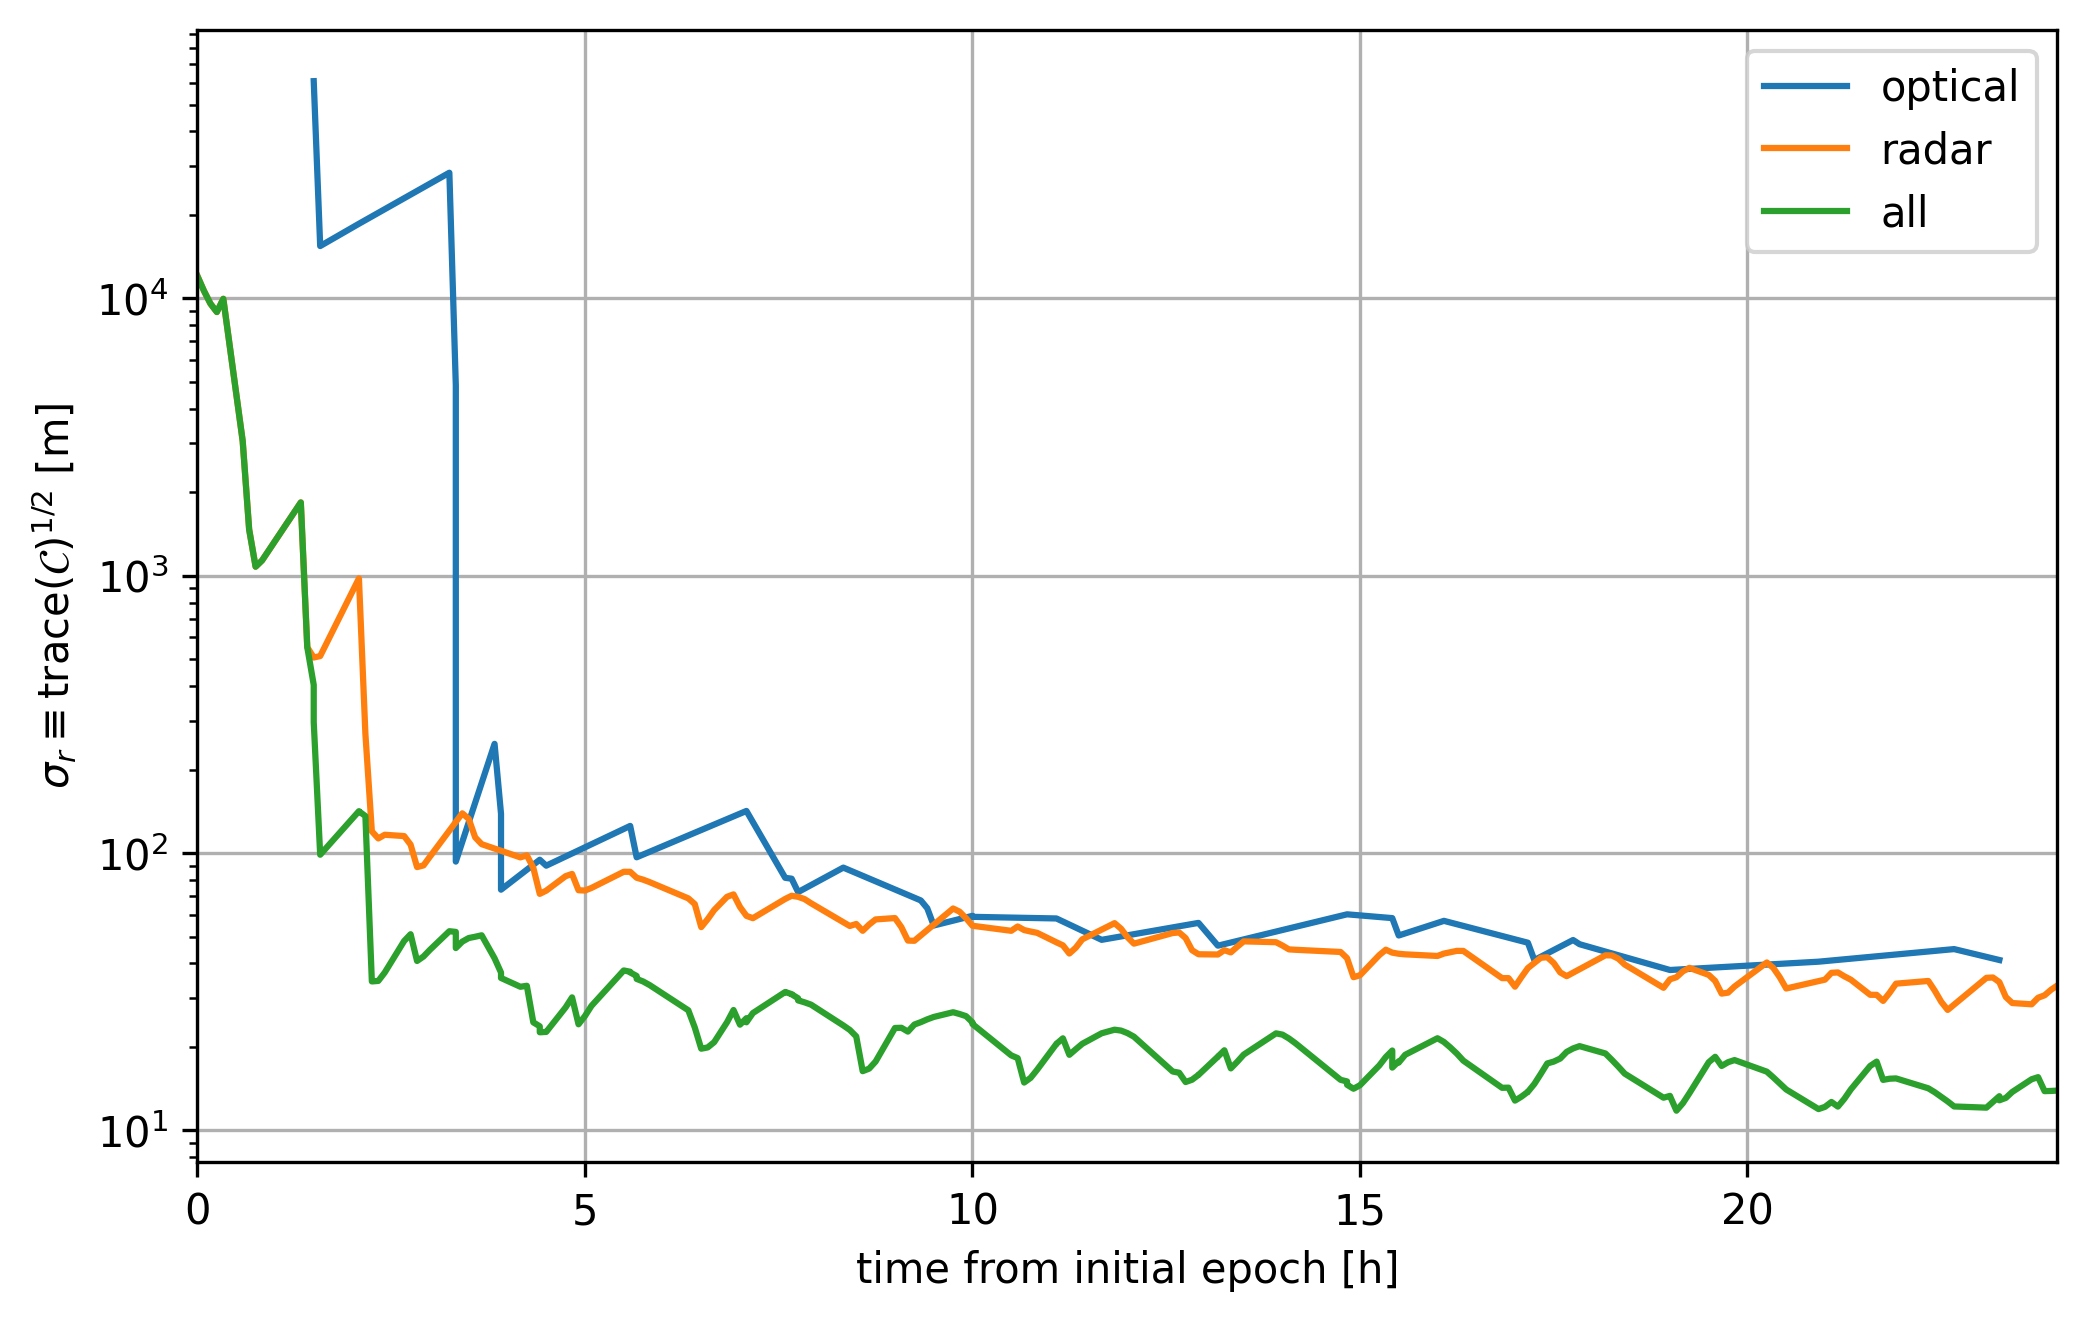

In [56]:
fig = plt.figure(figsize=(8,5),dpi=300)
P_size = [np.sqrt(np.sum((np.trace(P_hat)))) for P_hat in PhatsO]
plt.plot(obs[np.where(obs[:,0]==0)][:,2]*24/86400,P_size,label='optical')
P_size = [np.sqrt(np.sum((np.trace(P_hat)))) for P_hat in PhatsR]
plt.plot(obs[np.where(obs[:,0]==1)][:,2]*24/86400,P_size,label='radar')
P_size = [np.sqrt(np.sum((np.trace(P_hat)))) for P_hat in Phats]
plt.plot(obs[:,2]*24/86400,P_size,label='all')
# plt.ylim([0.01,10000])
plt.yscale('log')
plt.legend()
plt.xlim([0,24])
plt.ylabel('$\sigma_r \equiv $trace($\mathcal{C}$)$^{1/2}$ [m]')
plt.xlabel('time from initial epoch [h]')
# plt.scatter(obs[:,2],obs[:,0]+0.1,s=1)
plt.grid()

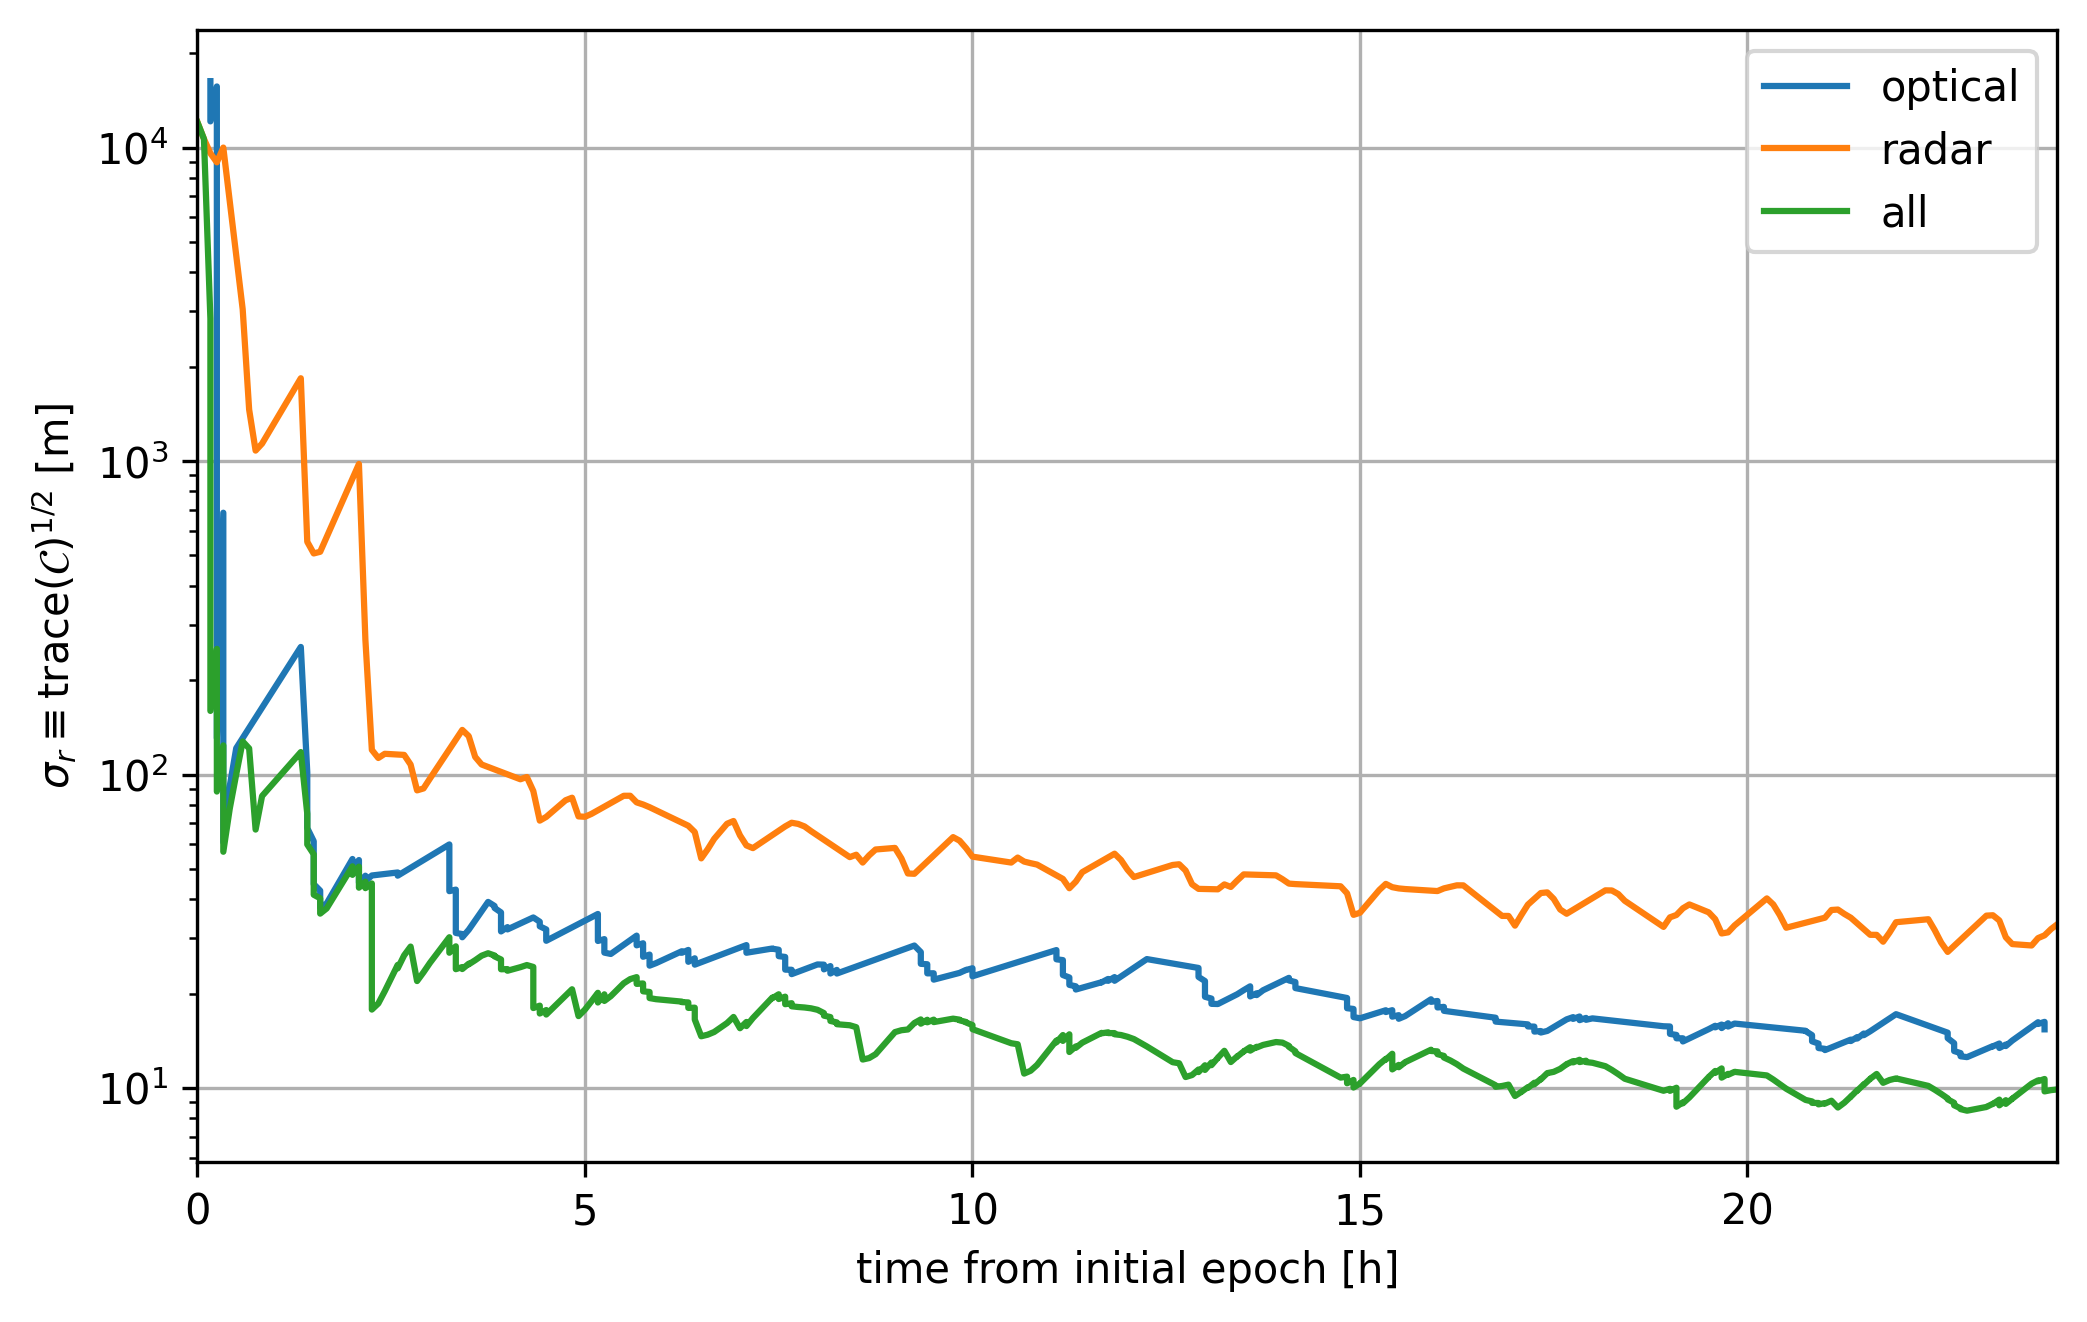

In [39]:
fig = plt.figure(figsize=(8,5),dpi=300)
P_size = [np.sqrt(np.sum((np.trace(P_hat)))) for P_hat in PhatsO]
plt.plot(obs[np.where(obs[:,0]==0)][:,2]*24/86400,P_size,label='optical')
P_size = [np.sqrt(np.sum((np.trace(P_hat)))) for P_hat in PhatsR]
plt.plot(obs[np.where(obs[:,0]==1)][:,2]*24/86400,P_size,label='radar')
P_size = [np.sqrt(np.sum((np.trace(P_hat)))) for P_hat in Phats]
plt.plot(obs[:,2]*24/86400,P_size,label='all')
# plt.ylim([0.01,10000])
plt.yscale('log')
plt.legend()
plt.xlim([0,24])
plt.ylabel('$\sigma_r \equiv $trace($\mathcal{C}$)$^{1/2}$ [m]')
plt.xlabel('time from initial epoch [h]')
# plt.scatter(obs[:,2],obs[:,0]+0.1,s=1)
plt.grid()

In [156]:
obs

array([[ 0.00000000e+00,  9.00000000e+00,  6.00000000e+02,
        -6.59805881e-01,  1.37869703e-01,  2.48575783e-01,
         0.00000000e+00,  0.00000000e+00,  2.48575783e-01,
         4.55610503e+06,  2.35487575e+06,  4.58314585e+06,
        -4.74476976e+03,  5.67396122e+03,  1.80142536e+03],
       [ 0.00000000e+00,  9.10000000e+01,  1.80000000e+03,
         4.06915537e-02, -5.46127019e-02,  7.74784072e-02,
         0.00000000e+00,  0.00000000e+00,  7.74784072e-02,
        -2.03019581e+06,  4.47440358e+06,  4.81318770e+06,
        -6.54919295e+03, -3.80297020e+03,  7.72851513e+02],
       [ 0.00000000e+00,  9.10000000e+01,  4.80000000e+03,
        -1.74018511e-01, -1.18015277e-01,  4.78573494e-02,
         0.00000000e+00,  0.00000000e+00,  4.78573494e-02,
         3.04999025e+06, -3.79214803e+06, -4.86065149e+06,
         6.04530146e+03,  4.62290941e+03,  1.86673230e+02],
       [ 0.00000000e+00,  0.00000000e+00,  5.40000000e+03,
        -1.63770458e-01, -1.39287908e-01,  5.30716064

In [180]:
def procef_obs(obsfile):
    with open(f"./code_data_files/{obsfile}.pkl", "rb") as f:
        obs = dill.load(f)
    Xhats, Phats, Phis, Ss = EKF(object_init_states[0], init_epoch, obs)
    return obs[:,2]*24/86400, [np.sqrt(np.sum((np.trace(P_hat)))) for P_hat in Phats]

In [181]:
t_0_3,result_0_3 = procef_obs('obs2_0_3')

 37%|████████████████                           | 19/51 [00:11<00:19,  1.63it/s]


TypeError: list indices must be integers or slices, not tuple

In [ ]:
t_0_10,result_0_10 = procef_obs('obs2_0_10')

In [ ]:
t_100_3,result_100_3 = procef_obs('obs2_100_3')

In [ ]:
t_1000_3,result_1000_3 = procef_obs('obs2_1000_3')

In [ ]:
t_100_10,result_100_10 = procef_obs('obs2_100_10')

In [ ]:
t_1000_10,result_1000_10 = procef_obs('obs2_1000_10')

In [ ]:
t_100_0,result_100_0 = procef_obs('obs2_100_0')

In [ ]:
t_1000_0,result_1000_0 = procef_obs('obs2_1000_0')

In [ ]:
with open("./code_data_files/result3n_0_3.pkl", "wb") as f:
    dill.dump(result_0_3, f)
with open("./code_data_files/result3n_100_3.pkl", "wb") as f:
    dill.dump(result_100_3, f)
with open("./code_data_files/result3n_1000_3.pkl", "wb") as f:
    dill.dump(result_1000_3, f)
with open("./code_data_files/result3n_100_0.pkl", "wb") as f:
    dill.dump(result_100_0, f)
with open("./code_data_files/result3n_1000_0.pkl", "wb") as f:
    dill.dump(result_1000_0, f)
with open("./code_data_files/result3n_0_10.pkl", "wb") as f:
    dill.dump(result_0_10, f)
with open("./code_data_files/result3n_100_10.pkl", "wb") as f:
    dill.dump(result_100_10, f)
with open("./code_data_files/result3n_1000_10.pkl", "wb") as f:
    dill.dump(result_1000_10, f)
    
with open("./code_data_files/t3n_0_3.pkl", "wb") as f:
    dill.dump(t_0_3, f)
with open("./code_data_files/t3n_100_3.pkl", "wb") as f:
    dill.dump(t_100_3, f)
with open("./code_data_files/t3n_1000_3.pkl", "wb") as f:
    dill.dump(t_1000_3, f)
with open("./code_data_files/t3n_100_0.pkl", "wb") as f:
    dill.dump(t_100_0, f)
with open("./code_data_files/t3n_1000_0.pkl", "wb") as f:
    dill.dump(t_1000_0, f)
with open("./code_data_files/t3n_0_10.pkl", "wb") as f:
    dill.dump(t_0_10, f)
with open("./code_data_files/t3n_100_10.pkl", "wb") as f:
    dill.dump(t_100_10, f)
with open("./code_data_files/t3n_1000_10.pkl", "wb") as f:
    dill.dump(t_1000_10, f)

In [ ]:
tns = [t_0_3, t_0_10, t_100_3, t_1000_3, t_100_10, t_1000_10, t_100_0, t_1000_0]
rns = [result_0_3, result_0_10, result_100_3, result_1000_3, result_100_10, result_1000_10, result_100_0, result_1000_0]
lbls = ["0_3", "0_10", "100_3", "1000_3", "100_10", "1000_10", "100_0", "1000_0"]
a = [0,0,100,1000,100,1000,100,1000]
b = [3,10,3,3,10,10,0,0]

In [ ]:
# fig = plt.figure(figsize=(8,5),dpi=300)
fig,axs = plt.subplots(1,2, width_ratios=[1.5, 1])
fig.set_size_inches(15,5)
fig.set_dpi(200)

plt.sca(axs[0])

# line = {0:':', 3:'--', 10:'solid'}
# color = {0:'tab:red',100:'tab:orange',1000:'tab:green'}

line = {0:':', 100:'--', 1000:'solid'}
color = {0:'tab:red',3:'tab:orange',10:'tab:green'}

# alpha = {0:0.5, 100:0.75,1000:1}
# color = {0:'lightgrey',100:'grey',1000:'black'}


for t,r,lbl,ah,bh in list(zip(tns,rns,lbls,a,b)):

    plt.plot(t-24,r,linestyle=line[ah],color=color[bh],alpha=1)#,color='black')

plt.plot([-1000],[0],linestyle = line[0], color='black',label='0 satellites')
plt.plot([-1000],[0],linestyle = line[100], color='black',label='100 satellites')
plt.plot([-1000],[0],linestyle = line[1000], color='black',label='1000 satellites')

plt.plot([-1000],[0], color=color[0],label='0 radars')
plt.plot([-1000],[0], color=color[3],label='3 radars')
plt.plot([-1000],[0], color=color[10],label='10 radars')

plt.legend()
plt.xlim([-24,0])
plt.ylabel('$\sigma_r \equiv $trace($\mathcal{C}$)$^{1/2}$ [m]')
plt.xlabel('time from present epoch [h]')
plt.yscale('log')
plt.legend(ncol=2)
# plt.ylim(0.1,300)
plt.grid()

plt.sca(axs[1])

medianr = -np.array([np.median(r) for r in rns])
datar = np.array([np.nan,*(-medianr)])[np.array([0,1,2,7,3,5,8,4,6])]
# idxr = np.argsort(medianr)
# arc = 0
# for nr,c,lin in list(zip(-medianr[idxr], [color[bh] for bh in np.array(b)[idxr]], [line[ah] for ah in np.array(a)[idxr]])):
#     plt.vlines(arc,3,nr,color=c,linestyle=lin,linewidth=5)
#     arc += 1
# # plt.bar(range(8), -medianr[idxr], color=[color[ah] for ah in np.array(b)[idxr]])
# plt.yscale('log')
# plt.ylim(3,300)
# plt.xlim([-1,8])
# nlbl = np.array([
#     "0 sats     3 radars",
#     "0 sats   10 radars",
#     "100 sats     3 radars",
#     "1000 sats     3 radars",
#     "100 sats   10 radars",
#     "1000 sats   10 radars",
#     "100 sats     0 radars",
#     "1000 sats     0 radars"
# ])
# plt.xticks([])
# # plt.xticks(range(8), nlbl[idxr], rotation='vertical')

# plt.ylabel('median $\sigma_r$ [m]')
# plt.grid('off')
# plt.grid(axis='y')

# c = plt.imshow((datar.reshape(3,3)),cmap='viridis', norm=matplotlib.colors.LogNorm(vmin=-medianr.max(), vmax=-medianr.min()))
# plt.colorbar(c,label='median $\sigma_r$ [m]')
# plt.clim(0.5,2)
plt.yticks([0,1,2], ['0','100','1000'])
plt.xticks([0,1,2], ['0','3','10'])
plt.ylabel('Satellites')
plt.xlabel('Radars')
plt.grid('off')

plt.grid()
plt.savefig('scenario4.png')

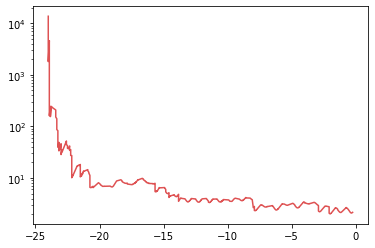

In [189]:
for t,r,lbl,ah,bh in list(zip(tns,rns,lbls,a,b)):
    if ah==1000 and bh==0:
        plt.plot(t-24,r,linestyle=line[ah],color=color[bh],alpha=0.8)#,color='black')
        
plt.yscale('log')

In [56]:
[line[ah] for ah in np.array(a)[idxr]]

['--', ':', ':', 'solid', '--', 'solid', '--', 'solid']

In [36]:
datar = np.array([np.nan,*(-medianr)])[np.array([0,1,2,7,3,5,8,4,6])]

<module 'matplotlib.pyplot' from '/home/koe/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

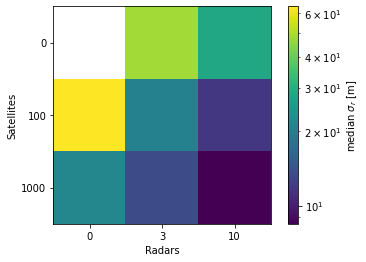

In [88]:
c = plt.imshow((datar.reshape(3,3)),cmap='viridis', norm=matplotlib.colors.LogNorm(vmin=-medianr.max(), vmax=-medianr.min()))
plt.colorbar(c,label='median $\sigma_r$ [m]')
# plt.clim(0.5,2)
plt.yticks([0,1,2], ['0','100','1000'])
plt.xticks([0,1,2], ['0','3','10'])
plt.ylabel('Satellites')
plt.xlabel('Radars')
plt